Importo le librerie necessarie e il dataset di commenti

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

comments_df = pd.read_csv('../reddit_comments.csv')
print(f'Numero di commenti: {comments_df.size}')
comments_df.head()

Numero di commenti: 52481


,comment_id,comment_author_id,comment_author_name,comment_parent_id,comment_parent_name,comment_score,comment_replies,comment_posted_time,comment_body,post_id,post_title,post_url,post_subreddit
0,k9yfohd,209w6fpg,moonwave91,0,OP,160,2,1.700439e+09,Il vero problema è l'immensa orda di giornalis...,17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
1,k9xjbzd,deleted,deleted,0,OP,310,3,1.700426e+09,"Non è un idiota l'ex ragazzo, è un assassino, ...",17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
2,k9zies2,e5pmjzs5c,MainDelay9804,0,OP,22,0,1.700459e+09,Sono sti ragazzetti sui social che ormai han p...,17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
3,k9xb0xr,utwr8mto,AlessandroIT,0,OP,83,1,1.700422e+09,"Non fatevi influenzare dai post, continuate ad...",17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
4,k9xmjhd,49phg2z0,CthulhuParty,0,OP,87,1,1.700427e+09,ti da fastidio perchè percepisci giustamente c...,17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5


# Creazione del grafo relativo a tutti i post

In [2]:
post_id_color = {}
post_id_title = {}
post_id_text = {}
np.random.seed(0)
color_list = ['yellow', 'green', 'blue', 'red', 'purple', 'orange', 'pink', 'brown']
l = len(color_list)
i = 0
for post_id in comments_df['post_id'].unique():
    post_id_color[post_id] = color_list[i%l]
    post_id_title[post_id] = comments_df[comments_df['post_id'] == post_id].iloc[0]['post_title'][0:20]
    i += 1

In [3]:
all_post_graph = ig.Graph(directed=True)
all_post_graph.add_vertex(name=comments_df.iloc[0]['comment_parent_id'], color='black', label = comments_df.iloc[0]['comment_parent_name'], post_id=comments_df.iloc[0]['post_id'])

for comment in comments_df.iloc[1:].iterrows():
    author_id = comment[1]['comment_author_id']
    author_name = comment[1]['comment_author_name']
    parent_id = comment[1]['comment_parent_id']
    comment_id = comment[1]['comment_id']
    post_id = comment[1]['post_id']
    comment_score = int(comment[1]['comment_score'])
    color = post_id_color[post_id]
    
    if author_id not in all_post_graph.vs['name']:
        if parent_id in all_post_graph.vs['name']:
            all_post_graph.add_vertex(name=author_id, label=author_name, color=color, post_id=post_id)
            all_post_graph.add_edge(author_id, parent_id, weight=comment_score, comment_id = comment_id)
    else:
        if parent_id in all_post_graph.vs['name'] and parent_id != author_id:
            all_post_graph.add_edge(author_id, parent_id, weight=comment_score, comment_id = comment_id)

all_post_graph.delete_vertices(['0','deleted'])

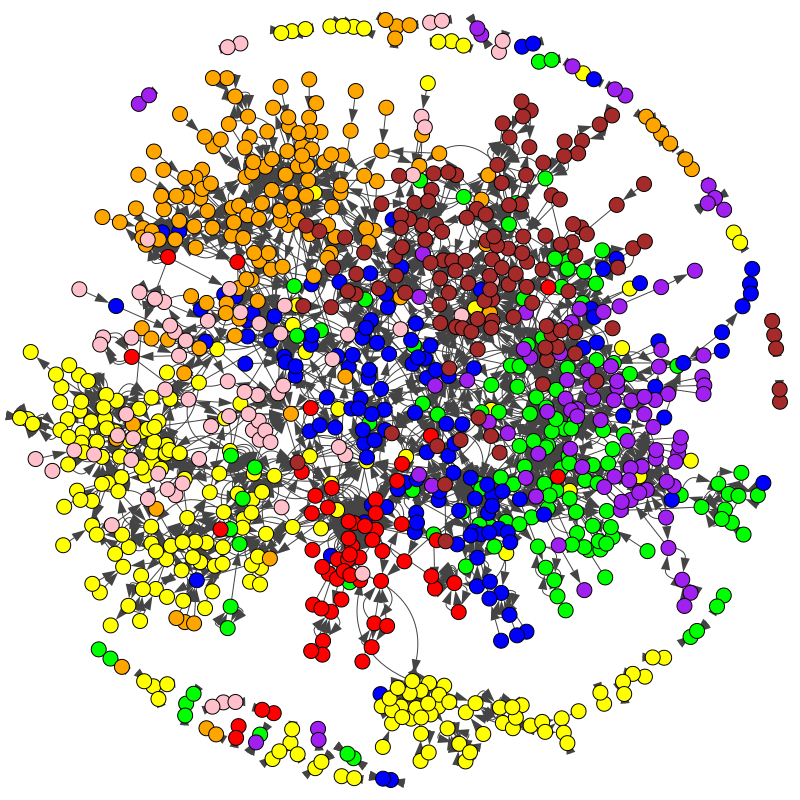

In [12]:
visual_style = {
    "vertex_label": None,
    "bbox": (800, 800),
    "vertex_size": 15,
}

all_post_graph.delete_vertices([v.index for v in all_post_graph.vs if v.neighbors() == []])
ig.plot(all_post_graph, **visual_style)

## Creazione e pulizia dei grafi separati

In [5]:
post_graphs = {}
visual_style = {
    "bbox": (1000, 1000),
    "vertex_label_size": 15
}
for post_id in set(all_post_graph.vs['post_id']):
    post_vertices = [v.index for v in all_post_graph.vs if v['post_id'] == post_id]
    subgraph = all_post_graph.subgraph(post_vertices)    
    post_graphs[post_id] = subgraph
    deleted_vertices = []
    for v in subgraph.vs:
        if v.neighbors() == []:
            deleted_vertices.append(v)

    subgraph.delete_vertices(deleted_vertices)
    ig.plot(subgraph,f'../graphs/post_graphs/post_graph_{post_id_title[post_id]}.png' ,**visual_style)

# Ricerca delle discussioni

In [6]:
def find_minimal_debate(graph):
    color_list = ['yellow', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'black','lightblue','lightgreen','lime','magenta','maroon','navy','olive','purple','silver','teal','white','yellow']
    i = 0
    for vertex in graph.vs:
        if vertex['debate_id'] == 0:
            color = color_list[i % len(color_list)]
            i += 1
            neighbors = vertex.neighbors()
            if neighbors != []:
                for vertex_neighbor in neighbors:
                    if vertex_neighbor['debate_id'] == 0:
                        try:
                            vertex_to_neighbor = graph.es.find(_source=vertex.index, _target=vertex_neighbor.index)
                        except:
                            vertex_to_neighbor = None
                        try:
                            neighbors_to_vertex = graph.es.find(_source=vertex_neighbor.index, _target=vertex.index)
                        except:
                            neighbors_to_vertex = None
                        if vertex_to_neighbor and neighbors_to_vertex:
                            vertex['color'] = color
                            vertex['debate_id'] = i
                            vertex_neighbor['color'] = color
                            vertex_neighbor['debate_id'] = i
                            break

def find_complete_discussion(vertex, graph):
    color = vertex['color']
    debate_id = vertex['debate_id']
    neighbors = vertex.neighbors()
    for neighbor in neighbors:
        if neighbor['debate_id'] != debate_id:
            try:
                vertex_to_neighbor = graph.es.find(_source=vertex.index, _target=neighbor.index)
            except:
                vertex_to_neighbor = None
            
            try:
                neighbors_to_vertex = graph.es.find(_source=neighbor.index, _target=vertex.index)
            except:
                neighbors_to_vertex = None

            if neighbors_to_vertex or (vertex_to_neighbor and neighbors_to_vertex):

                neighbor['color'] = color
                neighbor['debate_id'] = debate_id
                find_complete_discussion(neighbor, graph)

In [7]:
for single_post_graph in post_graphs.values():
    for vertex in single_post_graph.vs:
        vertex['debate_id'] = 0
    find_minimal_debate(single_post_graph)
    for vertex in single_post_graph.vs:
        if vertex['debate_id'] != 0:
            find_complete_discussion(vertex, single_post_graph)

    ig.plot(single_post_graph, f'../graphs/debate_graphs/debate_graph_{post_id_title[single_post_graph.vs[0]["post_id"]]}.png', **visual_style)

# Estrazione dei dataset a partire dai debate_graphs

In [8]:
i = 0

normalized_index = {}

for single_post_graph in post_graphs.values():
    for debate_id in single_post_graph.vs['debate_id']:
        if normalized_index.get(debate_id) == None:
            normalized_index[debate_id] = i
            i += 1
        else:
            continue

In [9]:
fieldnames = [
    'comment_id',
    'post_id',
    'debate_group',
    'comment_user_name',
    'commented_user_name',
    'comment_body',
    'comment_score'
    ]


with open(f'../debate_dataset.csv', 'a+') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for single_post_graph in post_graphs.values():
        i += 1
        for edge in single_post_graph.es:
            source = single_post_graph.vs[edge.source]
            target = single_post_graph.vs[edge.target]
            if source['debate_id'] != 0 and target['debate_id'] != 0:
                writer.writerow({
                    'comment_id': edge['comment_id'],
                    'post_id': source['post_id'],
                    'debate_group': normalized_index[source['debate_id']],
                    'comment_user_name': source['label'],
                    'commented_user_name': target['label'],
                    'comment_body': comments_df[comments_df['comment_id'] == edge['comment_id']].iloc[0]['comment_body'],
                    'comment_score': edge['weight']
                })